# measurement_error

> There are numerous problems that can occur when exogenous variables with measurment error are used in a regression model improperly. This notebook will demonstrate the problems that can occur when measurement error is present in the exogenous variables of a regression model. And some methods for mitigating the problems that can occur when measurement error is present in the exogenous variables of a regression model.

In [ ]:
#| default_exp measurement_error

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
#| hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import xarray as xr
from tueplots import bundles
from tueplots.constants.color import rgb

In [ ]:
#| hide

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

## Survey Data

When working with surveys and samples from a population, it is important to consider the precision of the population parameter estimates. The precision of the population parameter estimates is influenced by the sample size, the sampling design, and the measurement error in the survey data. 

When imprecise measures are used in a regression model, the estimates of the coefficients of the model will be biased and inconsistent. This can occur even when the sampling design is unbiased and respondents answers are entirely accurate. For survey data samples size is often limited, and the sampling design is often complex. This means that the measurement error in the survey data can have a significant impact on the precision of the population parameter estimates.

## Completely random measurement error in a binary outcome variable

Consider the following example:

> A survey is conducted weekly with an average of 500 participants each week. The survey asks participants if they recall seeing a particular brand's advertisement. Survey participents are randomly selected from the population and are well representative of the total population. The survey is conducted by phone and online.

First lets assume that all participants are able to recall the brand's advertisement with 100% accuracy. We would like to estimate the effect of a populations ability to recall the brand's advertisement on the brand's sales. We will use a simple linear regression model to estimate the effect of the populations ability to recall the brand's advertisement on the brand's sales.

Let us simulate the 3 years of survey data.


In [ ]:
#| export
def random_walk_awareness_model(
  periods: list | pd.DatetimeIndex | np.ndarray, # Time periods to simulate
  ) -> pm.Model: # PyMC model for the random walk awareness model
    coords = {
      'Period': periods,
    }
    with pm.Model(coords = coords) as model:
        #Random walk model
        weekly_variation = pm.HalfNormal('weekly_variation', sigma=.1)
        initial_awareness = pm.Normal('initial_awareness', mu=0, sigma=1)
        logit_awareness = pm.GaussianRandomWalk(
          'logit_awareness', 
          sigma=weekly_variation, 
          init_dist=pm.Normal.dist(mu=initial_awareness, sigma=.01), 
          dims="Period")
        
        weekly_shock = pm.HalfNormal('weekly_shock', sigma=.1)
        _noise = pm.Normal('_noise', mu=0, sigma=1, dims="Period")
        awareness = pm.Deterministic('awareness', pm.math.invlogit(logit_awareness + weekly_shock*_noise), dims="Period")
    return model

In [ ]:
dates = pd.date_range(start='2021-01-01', periods=156, freq='W-MON')
awareness_model = random_walk_awareness_model(dates)
starting_awareness = 0.025
logit_starting_awareness = np.log(starting_awareness/(1-starting_awareness))
generative_model = pm.do(
  awareness_model, 
  {
    'weekly_variation': .1, 
    'initial_awareness': logit_starting_awareness,
    'weekly_shock': .01
  }
)
population_awareness = pm.draw(generative_model['awareness'], random_seed=42)
population_awareness = xr.DataArray(
  population_awareness,
  dims=['Period'],
  coords={'Period': dates}
)

In [ ]:
#| export
def _rgb_to_hex(color):
    """Converts an RGB color array to a hex color string."""
    return "#{:02X}{:02X}{:02X}".format(*color.astype(int))

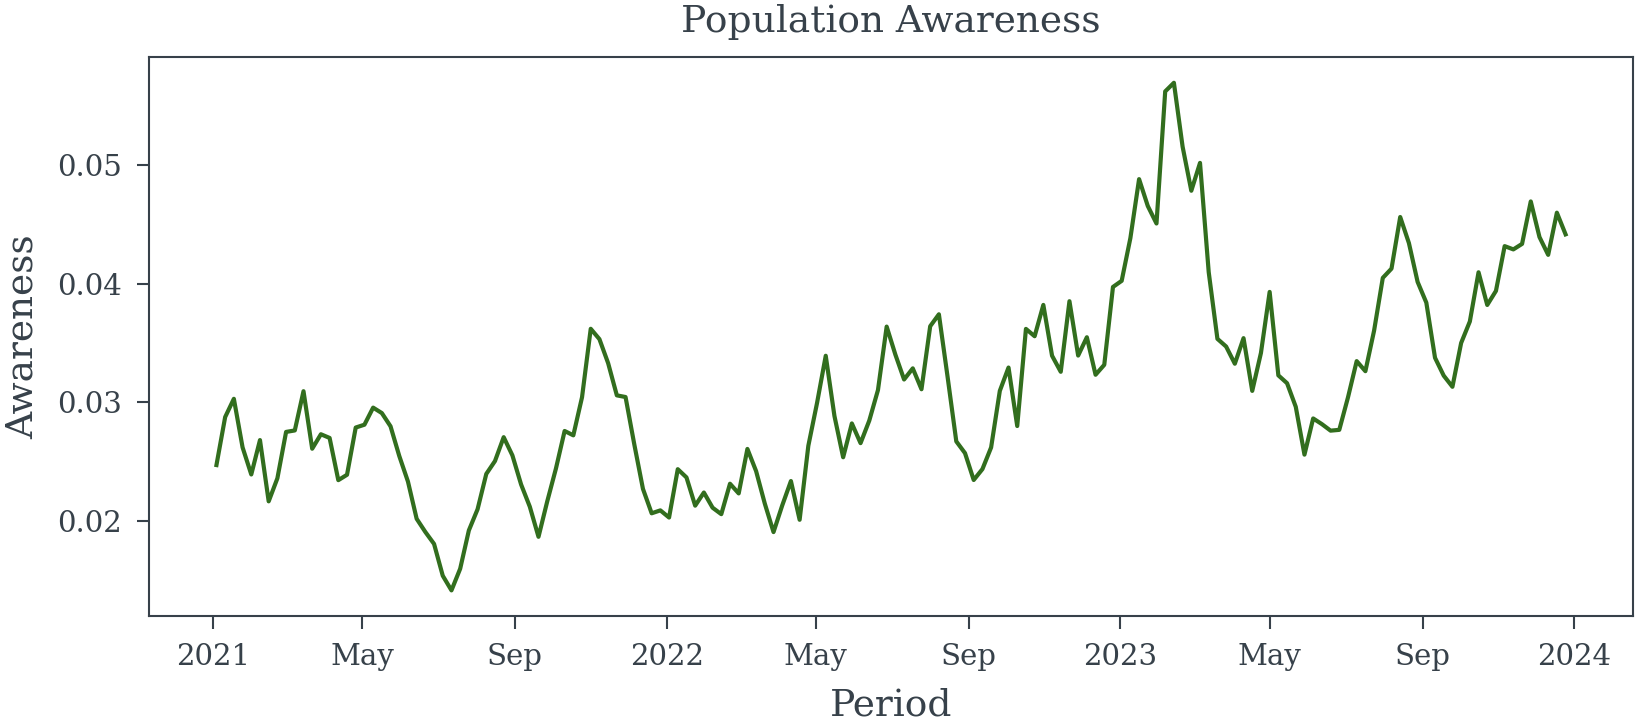

In [ ]:
#| echo: false
#| label: fig-population-awareness
#| fig-cap: Population Awareness
#plt.figure(figsize=(10, 5))
population_awareness.plot(c=_rgb_to_hex(rgb.tue_darkgreen*256))
plt.title('Population Awareness')
plt.ylabel('Awareness')
plt.xlabel('Period');

In [ ]:
#| export
def survey_obs_model(
  population_awareness: xr.DataArray | pm.pytensorf.TensorVariable, # Population awareness
  avg_weekly_participants: float = 500.0, # Average number of participants per week
  coords: dict = None, # Coordinates for the PyMC model
  model: pm.Model = None, # PyMC model to add the survey observation model
  ) -> pm.Model:
    if coords is None:
      assert isinstance(population_awareness, xr.DataArray), "If coords is not provided, population_awareness must be an xarray DataArray"
      coords = {
        'Period': population_awareness['Period'].values,
      }
      population_awareness = population_awareness.values
    try:
      model = pm.modelcontext(model)
    except TypeError:
      model = pm.Model(coords=coords)
    with model:
        N_survey_participant = pm.Poisson('n_survey_participants', avg_weekly_participants, dims="Period")
        N_positive = pm.Binomial('n_positive', N_survey_participant, population_awareness, dims="Period")
    return model

In [ ]:
#| export
def simulate_awareness_survey_data(
  start_date: str = '2020-01-01', # Start date of the survey data
  n_weeks: int = 156, # Number of weeks to simulate
  avg_weekly_participants: float = 500.0, # Average number of participants per week
  weekly_awareness_variation: float = 0.08, # Std. dev. of gaussian inovations for weekly awareness
  starting_population_aware: float = 0.025, # Starting population awareness
  weekly_shock: float = 0.01, # Std. dev. of gaussian noise for weekly deviation from random walk
  random_seed: int = 42, # Random seed for reproducibility
) -> xr.Dataset: # Simulated awareness survey data as an xarray dataset
  dates = pd.date_range(start=start_date, periods=n_weeks, freq='W-MON')
  awareness_model = random_walk_awareness_model(dates)
  gen_model = pm.do(
    awareness_model, 
    {
      'weekly_variation': weekly_awareness_variation, 
      'initial_awareness': np.log(starting_population_aware/(1-starting_population_aware)),
      'weekly_shock': .01
    }
  )
  
  with gen_model:
    survey_obs_model(gen_model['awareness'], avg_weekly_participants=avg_weekly_participants, coords={'Period': dates})
    trace = pm.sample_prior_predictive(1, random_seed=random_seed)
  
  trace = trace.prior.isel(chain=0, draw=0).drop_vars('chain').drop_vars('draw')
  return trace.assign(estimated_awareness = trace['n_positive']/trace['n_survey_participants'])


In [ ]:
#| export
def plot_survey_sim_data(
  data: xr.Dataset, # Simulated survey data must contain 'awareness' and 'estimated_awareness' variables
) -> None: # Plot of the simulated survey data
    #plt.figure(figsize=(10, 5))
    data.estimated_awareness.plot.scatter(x='Period', color=_rgb_to_hex(rgb.tue_gray*256), label='Simulated Survey Data')
    data.awareness.plot(color=_rgb_to_hex(rgb.tue_darkgreen*256), ls='--', label="Population Awareness")
    plt.legend()
    plt.title('Simulated Awareness Survey Data');

Sampling: [_noise, logit_awareness, n_positive, n_survey_participants]


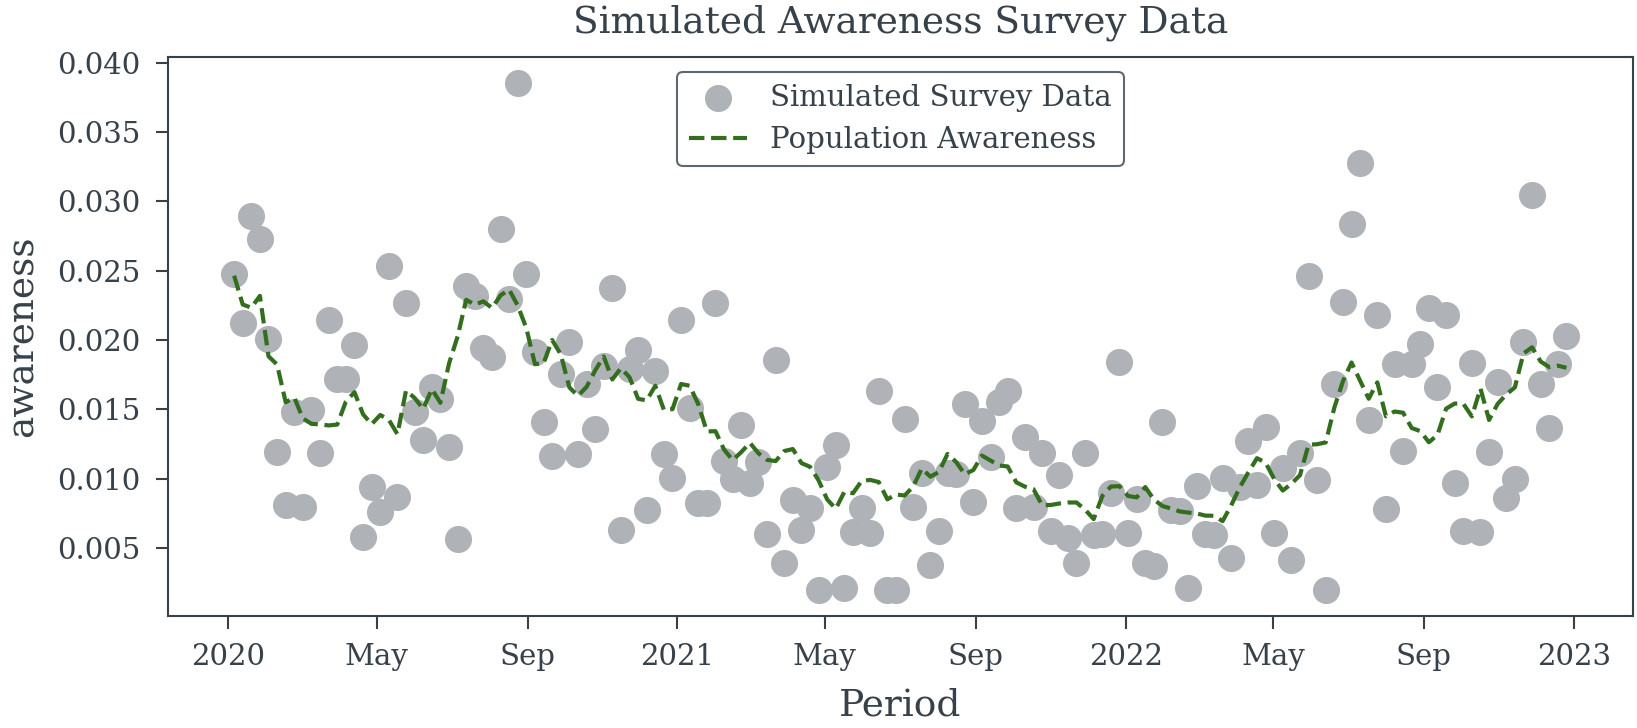

In [ ]:
#| label: fig-survey-sim-data
#| fig-cap: Simulated Awareness Survey Data
trace = simulate_awareness_survey_data(random_seed=23)
plot_survey_sim_data(trace)

## Let's simulate some sales data

The sales data is simulated using the following equation:

$$
\begin{align*}
log(S_t) &= \beta \text{pop\_awareness}_t + \alpha + \varepsilon_t \\
\varepsilon_t &\sim \mathcal{N}(0, \sigma^2)
\end{align*}
$$

Lets see if the true coeff $\beta$ can be estimated using the simulated data.

In [ ]:
ACTUAL_AWARENESS_COEFF = 30
log_sales = trace.awareness*ACTUAL_AWARENESS_COEFF + 10 + np.random.normal(0, 0.03, trace.awareness.shape)
sales = np.exp(log_sales)

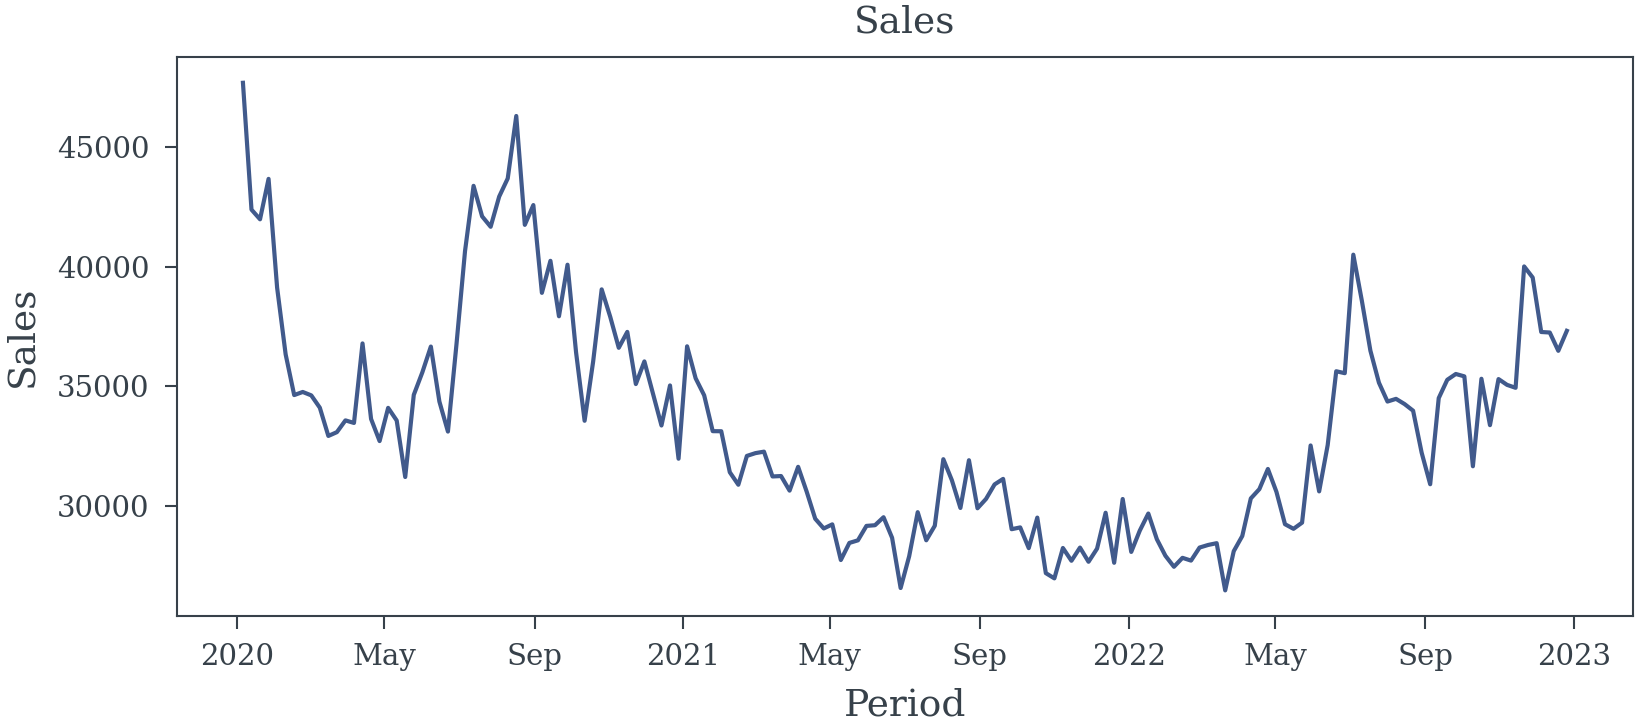

In [ ]:
#| echo: false
#| label: fig-simulated-sales
#| fig-cap: Simulated sales data
#plt.figure(figsize=(10, 5))
sales.plot(c=_rgb_to_hex(rgb.tue_darkblue*256))
plt.ylabel('Sales')
plt.title('Sales');

### The naive model

Let's try ignoring the data generation process and fit a simple linear regression model to the data.

In [ ]:
#| echo: false
#| label: tbl-measurement-error
#| tbl-cap: Using estimated awareness to predict sales
naive_model = sm.OLS(log_sales.to_series(), sm.add_constant(trace.estimated_awareness.to_series())).fit(cov_type="HAC", cov_kwds={'maxlags':1})
naive_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              awareness   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     115.7
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           1.78e-20
Time:                        00:30:15   Log-Likelihood:                 141.71
No. Observations:                 156   AIC:                            -279.4
Df Residuals:                     154   BIC:                            -273.3
Df Model:                           1                                         
Covariance Type:                  HAC                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.2393      0.017    587.550      0.000      10.205      10.273
estimated_awareness    12.4845      1.161     10.756      0.000      10.210      14.760
==============================================================================
Omnibus:                        3.239   Durbin-Watson:                   1.064
Prob(Omnibus):                  0.198   Jarque-Bera (JB):                3.266
Skew:                           0.321   Prob(JB):                        0.195
Kurtosis:                       2.700   Cond. No.                         142.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

We can see that the estimated coefficient is biased. The true coefficient for the effect of the populations ability to recall the brand's advertisement on the brand's sales is 30. The estimated coefficient is much less.

### Next the simple moving average model

Let's try a simple moving average model to see if we can improve the estimate of the coefficient. We will ignore the data generation process and take the moving average of the estimated awareness directly.

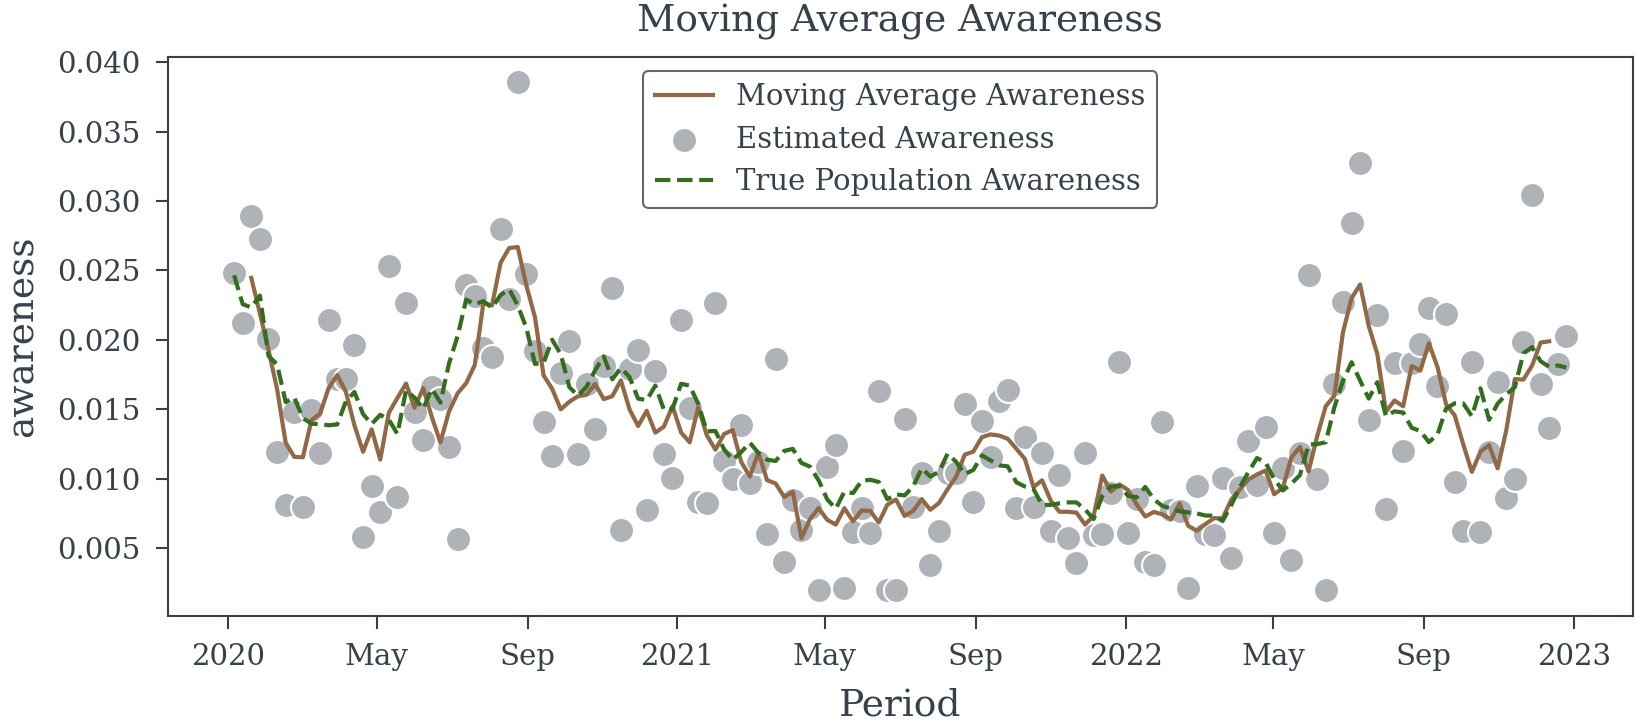

In [ ]:
#| echo: false
#| label: fig-mov-avg-awareness-1
#| fig-cap: Moving average awareness
#plt.figure(figsize=(10, 5))
moving_avg_awareness = trace.estimated_awareness.rolling(Period=5).mean().shift(Period=-2)
moving_avg_awareness.plot(c=_rgb_to_hex(rgb.tue_brown*256), label='Moving Average Awareness')
trace.estimated_awareness.plot.scatter(c=_rgb_to_hex(rgb.tue_gray*256), label='Estimated Awareness')
trace['awareness'].plot(c=_rgb_to_hex(rgb.tue_darkgreen*256), ls='--', label='True Population Awareness')
plt.legend()
plt.title('Moving Average Awareness');

In [ ]:
#| echo: false
#| label: tbl-moving-avg-model
#| tbl-cap: Using moving average awareness as a predictor
moving_avg_model = sm.OLS(log_sales.to_series()[2:-2], sm.add_constant(moving_avg_awareness.to_series()[2:-2])).fit(cov_type="HAC", cov_kwds={'maxlags':1})
moving_avg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              awareness   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     266.8
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           4.16e-35
Time:                        00:12:23   Log-Likelihood:                 193.02
No. Observations:                 152   AIC:                            -382.0
Df Residuals:                     150   BIC:                            -376.0
Df Model:                           1                                         
Covariance Type:                  HAC                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.1040      0.017    595.823      0.000      10.071      10.137
estimated_awareness    23.3556      1.430     16.335      0.000      20.553      26.158
==============================================================================
Omnibus:                        2.919   Durbin-Watson:                   0.674
Prob(Omnibus):                  0.232   Jarque-Bera (JB):                2.476
Skew:                           0.295   Prob(JB):                        0.290
Kurtosis:                       3.205   Cond. No.                         209.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

Already we are doing better than the naive model. The estimated coefficient is closer to the true coefficient. However, the estimated coefficient is still biased.

### Moving Average (Correctly this time)

Let's try a moving average model again, but this time we will take the moving average of the number of survey participants and the number of positive results before dividing each.

In [ ]:
moving_sum_n_positive = trace.n_positive.rolling(Period=5).sum().shift(Period=-2)
moving_sum_n_participants = trace.n_survey_participants.rolling(Period=5).sum().shift(Period=-2)
moving_avg_awareness = moving_sum_n_positive/moving_sum_n_participants

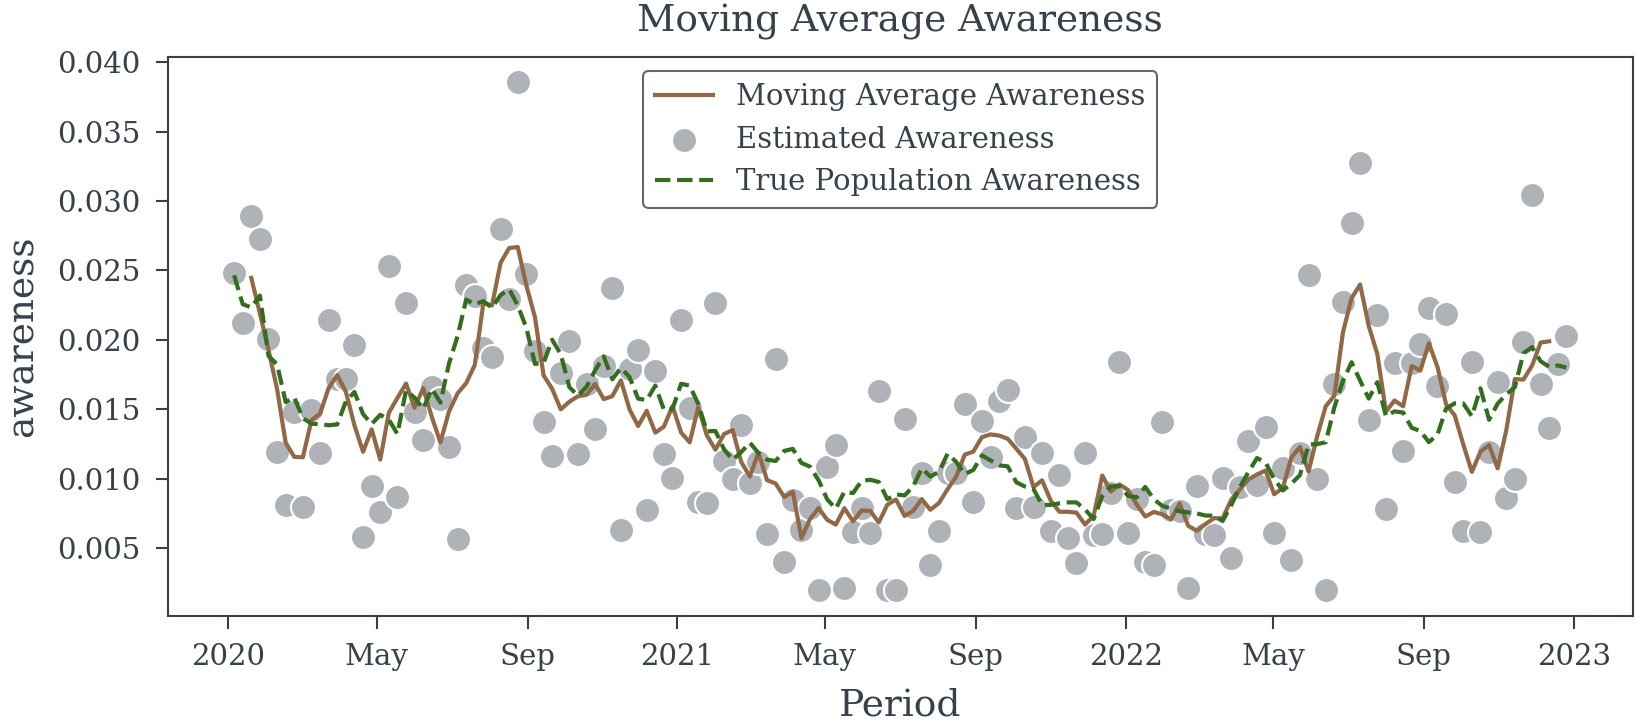

In [ ]:
#| echo: false
#| label: fig-mov-avg-awareness-2
#| fig-cap: Moving average awareness second approach
moving_avg_awareness.plot(c=_rgb_to_hex(rgb.tue_brown*256), label='Moving Average Awareness')
trace.estimated_awareness.plot.scatter(c=_rgb_to_hex(rgb.tue_gray*256),  label='Estimated Awareness')
trace['awareness'].plot(c=_rgb_to_hex(rgb.tue_darkgreen*256), ls='--', label='True Population Awareness')
plt.legend()
plt.title('Moving Average Awareness');

In [ ]:
#| echo: false
#| label: tbl-corrected-moving-avg
#| tbl-cap: Corrected Moving Average Model
moving_avg_model = sm.OLS(log_sales.to_series()[2:-2], sm.add_constant(moving_avg_awareness.to_dataframe("Moving Avg Awareness")[2:-2])).fit(cov_type="HAC", cov_kwds={'maxlags':1})
moving_avg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              awareness   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     275.3
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           9.21e-36
Time:                        00:12:26   Log-Likelihood:                 192.60
No. Observations:                 152   AIC:                            -381.2
Df Residuals:                     150   BIC:                            -375.1
Df Model:                           1                                         
Covariance Type:                  HAC                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.1028      0.017    599.379      0.000      10.070      10.136
Moving Avg Awareness    23.4995      1.416     16.591      0.000      20.723      26.276
==============================================================================
Omnibus:                        3.728   Durbin-Watson:                   0.670
Prob(Omnibus):                  0.155   Jarque-Bera (JB):                3.228
Skew:                           0.326   Prob(JB):                        0.199
Kurtosis:                       3.291   Cond. No.                         210.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

This model is only slightly better than the simple moving average model. The estimated coefficient is still biased.

### Latent Variable Model
Let us now try to first estimate the population level awareness using a bayesian model and then use the estimated population level awareness in the regression model.

In [ ]:
#| output: false
dates = trace["Period"].values
awareness_model = random_walk_awareness_model(dates)

with awareness_model as survey_model:
    survey_obs_model(awareness_model['awareness'], avg_weekly_participants=500, coords={'Period': dates})
    
with pm.observe(
  pm.do(
    survey_model, 
    {'n_survey_participants': trace.n_survey_participants.values} # apply the number of survey participants
    ), 
  {'n_positive': trace.n_positive.values} # observe the number of positive responses
  ):
    obs_trace = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weekly_variation, initial_awareness, logit_awareness, weekly_shock, _noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


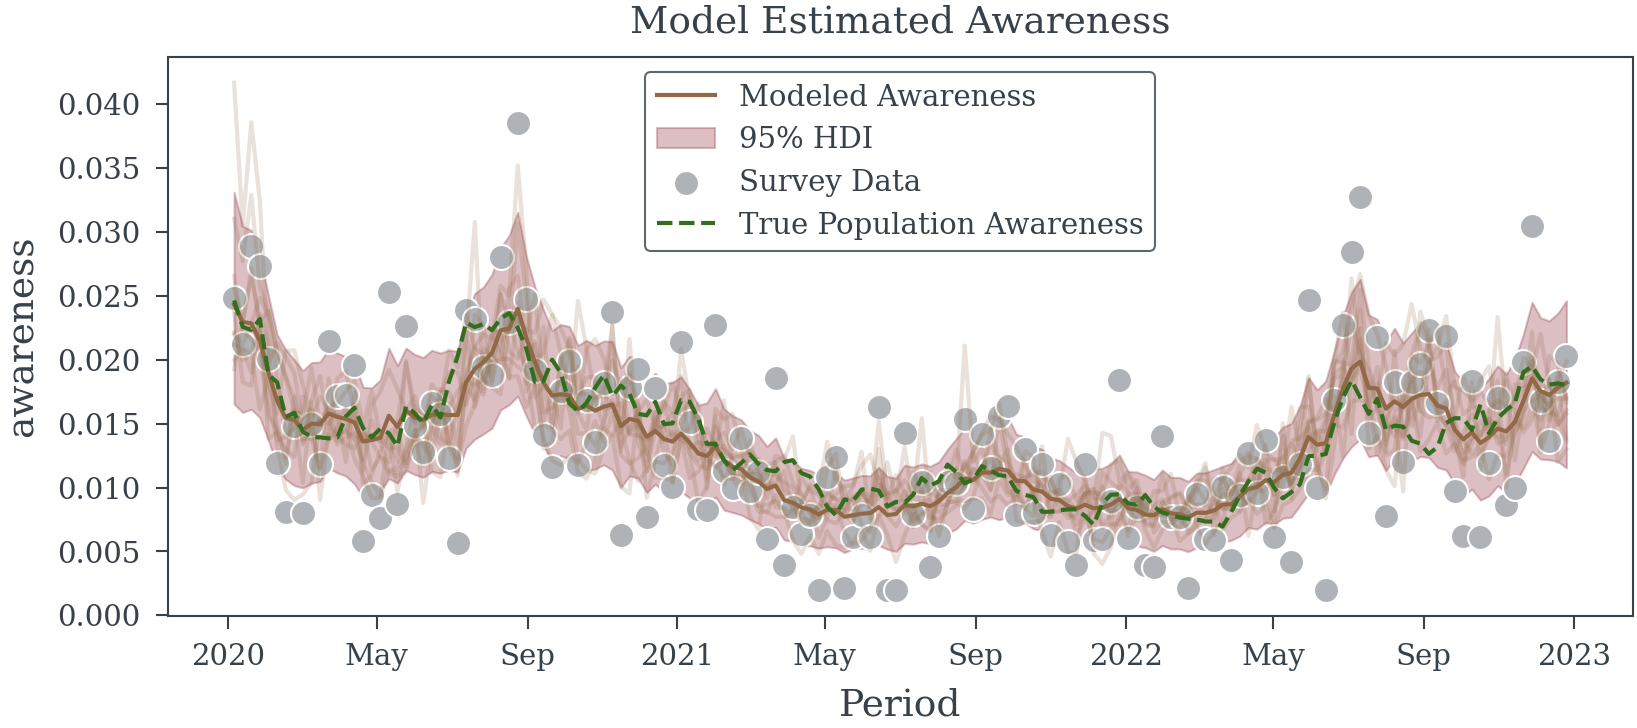

In [ ]:
#| echo: false
#| label: fig-modeled-awareness
#| fig-cap: Modeled Awareness
#plt.figure(figsize=(10, 5))
obs_hdi = pm.hdi(obs_trace.posterior['awareness'], hdi_prob=0.95).awareness
obs_trace.posterior['awareness'].mean(dim=('draw','chain')).plot(c=_rgb_to_hex(rgb.tue_brown*256), label='Modeled Awareness')
plt.fill_between(obs_hdi.Period, obs_hdi.sel(hdi='lower'), obs_hdi.sel(hdi='higher'), color=_rgb_to_hex(rgb.tue_red*256), alpha=0.3, label='95% HDI')
obs_trace.posterior['awareness'].isel(chain=0, draw=slice(0, 100, 10)).plot(x='Period', hue='draw', color=_rgb_to_hex(rgb.tue_brown*256), alpha=0.2)
trace['estimated_awareness'].plot.scatter(c=_rgb_to_hex(rgb.tue_gray*256), label='Survey Data')
trace['awareness'].plot(c=_rgb_to_hex(rgb.tue_darkgreen*256), ls='--', label='True Population Awareness')
plt.title('Model Estimated Awareness')
plt.legend();

In [ ]:
#| echo: false
#| label: tbl-modeled-awareness
#| tbl-cap: Using modeled awareness to estimate sales
estimated_model = sm.OLS(log_sales.to_series(), sm.add_constant(obs_trace.posterior['awareness'].mean(dim=('chain', 'draw')).to_series())).fit(cov_type="HAC", cov_kwds={'maxlags':1})
estimated_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              awareness   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     761.5
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           1.73e-61
Time:                        00:39:50   Log-Likelihood:                 246.84
No. Observations:                 156   AIC:                            -489.7
Df Residuals:                     154   BIC:                            -483.6
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0198      0.014    741.353      0.000       9.993      10.046
awareness     28.8895      1.047     27.595      0.000      26.838      30.941
==============================================================================
Omnibus:                        3.581   Durbin-Watson:                   1.058
Prob(Omnibus):                  0.167   Jarque-Bera (JB):                3.466
Skew:                          -0.196   Prob(JB):                        0.177
Kurtosis:                       3.616   Cond. No.                         238.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()